### **Impoort Required Libraries**

In [3277]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from sklearn.covariance import MinCovDet
from scipy.stats import chi2,shapiro,ks_2samp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import prince
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

### **Import Dataset**

In [3278]:
ml_project=pd.read_csv("../dataset/online_furniture_retailer.csv")

In [3279]:
ml_project.head()

product_category product_subcategory             brand  delivery_status  \
0          Outdoor           Patio Set      World Market  Failed Delivery   
1      Living Room                Sofa          West Elm        Cancelled   
2      Dining Room           Bar Stool  Ashley Furniture        Delivered   
3      Dining Room       China Cabinet         HomeGoods          Pending   
4      Dining Room       China Cabinet               CB2          Pending   

   assembly_service_requested    payment_method  order_id  customer_id  \
0                        True       Credit Card     93810         2824   
1                        True         Apple Pay     13278         5506   
2                       False  Cash on Delivery     42098         4657   
3                       False        Google Pay     28289         2679   
4                        True         Apple Pay     98696         9935   

   product_price  shipping_cost  assembly_cost  total_amount  \
0         191.27          45.63          86.82        323.72   
1         702.87          52.65         183.07        938.59   
2         395.41          96.79           0.00        492.20   
3         602.59           0.00           0.00        602.59   
4        1782.36          69.23          41.53       1893.12   

   delivery_window_days  customer_rating  
0                    11              3.2  
1                    10              4.5  
2                     2              NaN  
3                     9              NaN  
4                    13              1.3

In [3280]:
ml_project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_category            1938 non-null   object 
 1   product_subcategory         1938 non-null   object 
 2   brand                       1842 non-null   object 
 3   delivery_status             1938 non-null   object 
 4   assembly_service_requested  1938 non-null   bool   
 5   payment_method              1938 non-null   object 
 6   order_id                    1938 non-null   int64  
 7   customer_id                 1938 non-null   int64  
 8   product_price               1938 non-null   float64
 9   shipping_cost               1880 non-null   float64
 10  assembly_cost               1900 non-null   float64
 11  total_amount                1938 non-null   float64
 12  delivery_window_days        1938 non-null   int64  
 13  customer_rating             1658 

In [3281]:
##make assembly_service_requested object
ml_project["assembly_service_requested"]=ml_project["assembly_service_requested"].astype("object")

### **Remove Redundent Features**

In [3282]:
ml_project=ml_project.drop(columns=["order_id","customer_id"])

In [3283]:
ml_project.describe()

product_price  shipping_cost  assembly_cost  total_amount  \
count    1938.000000    1880.000000    1900.000000   1938.000000   
mean     1155.930026      69.622250      62.698137   1288.390010   
std       658.490908      47.555003      82.552601    669.228652   
min        81.430000       0.000000       0.000000    146.930000   
25%       609.242500      32.585000       0.000000    722.707500   
50%      1076.230000      74.055000      26.285000   1224.175000   
75%      1628.550000     107.735000     106.115000   1758.500000   
max      2979.560000     150.000000     299.350000   3093.290000   

       delivery_window_days  customer_rating  
count           1938.000000      1658.000000  
mean               7.528380         3.059047  
std                3.987004         1.152078  
min                1.000000         1.000000  
25%                4.000000         2.100000  
50%                8.000000         3.100000  
75%               11.000000         4.000000  
max               14.000000         5.000000

### **Check Duplicate Records**

In [3284]:
ml_project.duplicated().sum() ##no duplicate records found

np.int64(0)

In [3285]:
print(f"Shape of the dataset is: {ml_project.shape}")

Shape of the dataset is: (1938, 12)


### **Split Dataset into Training and Testing**

In [3286]:
X=ml_project.drop(columns=["delivery_status"],axis=1)
Y=ml_project["delivery_status"]

In [3287]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=2,stratify=Y)

In [3288]:
print(f"Shape of the training data is:{X_train.shape} and {Y_train.shape}")
print(f"Shape of the testing data is:{X_test.shape} and {Y_test.shape}")

Shape of the training data is:(1550, 11) and (1550,)
Shape of the testing data is:(388, 11) and (388,)


### **Check Missing Values**

In [3289]:
X_train.isnull().sum() ##missing values for training set

product_category                0
product_subcategory             0
brand                          76
assembly_service_requested      0
payment_method                  0
product_price                   0
shipping_cost                  47
assembly_cost                  31
total_amount                    0
delivery_window_days            0
customer_rating               221
dtype: int64

In [3290]:
X_test.isnull().sum() ##missing values for testing set

product_category               0
product_subcategory            0
brand                         20
assembly_service_requested     0
payment_method                 0
product_price                  0
shipping_cost                 11
assembly_cost                  7
total_amount                   0
delivery_window_days           0
customer_rating               59
dtype: int64

### **Impute Missing Values**

In [3291]:
# ##impute brand name 
# brand_name=X_train[~X_train["brand"].isnull()][["total_amount"]]
# without_brand_name=X_train[X_train["brand"].isnull()][["total_amount"]]

# plt.figure(figsize=(10,5))
# sns.histplot(data=brand_name,x="total_amount",color="blue",kde=True,label="With Brand Name")
# sns.histplot(data=without_brand_name,x="total_amount",color="red",kde=True,label="Without Brand Name")
# plt.legend()
# plt.show()

##### A distributional comparison between orders with and without brand names shows that both groups exhibit a similar total amount distribution.
##### This suggests that missing brand values are not systematically associated with purchase value and are likely missing at random.
##### Therefore, imputing missing brand names with a ‘Generic’ category is appropriate and does not distort the monetary characteristics of the dataset.The ‘Generic’ label reflects unbranded or unrecorded suppliers rather than a distinct pricing segment.

##### Statistically check wheather these two distributions are same or not

In [3292]:
# ##check the normality of the two data samples using shapiro test

# ##with the brand name sample
# stat_1,p_val_1=shapiro(brand_name)
# ##without brand names
# stat_2,p_val_2=shapiro(without_brand_name)

# sig_level=0.05

# print(f"P value for Brand name data:{p_val_1}")
# print(f"P value for without Brand name data:{p_val_2}")

# # Interpretation
# if (p_val_1 and p_val_2) > sig_level:
#     print("Fail to reject H₀: Data looks normally distributed.")
# else:
#     print("Reject H₀: Data does not look normally distributed.")

In [3293]:
# ##Apply KS test 
# stat, p_value = ks_2samp(brand_name,without_brand_name)
# if p_value < 0.05:
#     print("Distributions differ")
# else:
#     print("Distributions are similar")

In [3294]:
# ##impute missing brand name with the "Generic" brand
# X_train["brand"].fillna("Generic",inplace=True)
# X_test["brand"].fillna("Generic",inplace=True)

In [3295]:
##Impute missing values for assembly_cost
##X_train.loc[(X_train["assembly_service_requested"]==False) & (X_train["assembly_cost"].isnull()),"assembly_cost"]=0 
##X_test.loc[(X_test["assembly_service_requested"]==False) & (X_test["assembly_cost"].isnull()),"assembly_cost"]=0

In [3296]:
##plt.Figure(figsize=(10,5))
##sns.histplot(data=X_train,x="assembly_cost",kde=True)
##plt.show()

In [3297]:
##X_train["assembly_cost"].fillna(X_train[X_train["assembly_service_requested"]==True]["assembly_cost"].median().round(2),inplace=True)
##X_test["assembly_cost"].fillna(X_train[X_train["assembly_service_requested"]==True]["assembly_cost"].median().round(2),inplace=True)

In [3298]:
##Impute missing values for shipping cost
# zero_shipping=X_train[X_train["shipping_cost"]==0][["product_subcategory","delivery_window_days","product_price"]]
# null_shipping=X_train[X_train["shipping_cost"].isnull()][["product_subcategory","delivery_window_days","product_price"]]
# non_zero_shipping=X_train[~((X_train["shipping_cost"]==0) | (X_train["shipping_cost"].isnull()))][["product_subcategory","delivery_window_days","product_price"]]


# plt.figure(figsize=(10,5))
# sns.histplot(data=non_zero_shipping,x="product_price",color="blue",kde=True,label="Non zero shipping cost")
# sns.histplot(data=zero_shipping,x="product_price",color="red",kde=True,label="Zero Shipping cost")
# sns.histplot(data=null_shipping,x="product_price",color="green",kde=True,label="Null Shipping")

# plt.legend()
# plt.show()


# plt.figure(figsize=(10,5))
# sns.histplot(data=non_zero_shipping,x="delivery_window_days",color="blue",kde=True,label="Non zero shipping cost")
# sns.histplot(data=zero_shipping,x="delivery_window_days",color="red",kde=True,label="Zero Shipping cost")
# sns.histplot(data=null_shipping,x="delivery_window_days",color="green",kde=True,label="Null Shipping")

# plt.legend()
# plt.show()

In [3299]:
##X_train["shipping_cost"].fillna(X_train["shipping_cost"].median().round(2),inplace=True)
##X_test["shipping_cost"].fillna(X_train["shipping_cost"].median().round(2),inplace=True)

In [3300]:
##Impute missing values for customer rating
# train_data=pd.concat([X_train,Y_train],axis=1)

# non_null_rating=train_data[~train_data["customer_rating"].isnull()][["delivery_status","product_price","customer_rating"]]
# null_rating=train_data[train_data["customer_rating"].isnull()][["delivery_status","product_price","customer_rating"]]

# plt.figure(figsize=(10,5))
# sns.boxplot(data=non_null_rating,x="delivery_status",y="customer_rating")
# plt.show()


In [3301]:
##plt.figure(figsize=(10,5))
##sns.scatterplot(data=non_null_rating,x="product_price",y="customer_rating",hue="delivery_status")
##plt.show()

In [3302]:

# X_train["customer_rating"].fillna(train_data["customer_rating"].median().round(2),inplace=True)
# X_test["customer_rating"].fillna(train_data["customer_rating"].median().round(2),inplace=True)

In [3303]:
numerical_features=X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features=X_train.select_dtypes(include=["object"]).columns.tolist()

# Define separate pipelines
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

# Combine with ColumnTransformer
imputation_pipeline = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
],
  remainder="drop"
)

In [3304]:
X_train_impute= imputation_pipeline.fit_transform(X_train)
X_test_impute= imputation_pipeline.transform(X_test)

In [3305]:
feature_names = numerical_features + categorical_features
X_train_impute= pd.DataFrame(X_train_impute, columns=feature_names, index=X_train.index)
X_test_impute= pd.DataFrame(X_test_impute, columns=feature_names, index=X_test.index)

In [3306]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1550 entries, 472 to 1658
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_category            1550 non-null   object 
 1   product_subcategory         1550 non-null   object 
 2   brand                       1474 non-null   object 
 3   assembly_service_requested  1550 non-null   object 
 4   payment_method              1550 non-null   object 
 5   product_price               1550 non-null   float64
 6   shipping_cost               1503 non-null   float64
 7   assembly_cost               1519 non-null   float64
 8   total_amount                1550 non-null   float64
 9   delivery_window_days        1550 non-null   int64  
 10  customer_rating             1329 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 145.3+ KB


In [3307]:
X_train_impute["product_price"]=X_train_impute["product_price"].astype("float64")
X_train_impute["shipping_cost"]=X_train_impute["shipping_cost"].astype("float64")
X_train_impute["assembly_cost"]=X_train_impute["assembly_cost"].astype("float64")
X_train_impute["total_amount"]=X_train_impute["total_amount"].astype("float64")
X_train_impute["delivery_window_days"]=X_train_impute["delivery_window_days"].astype("float64")
X_train_impute["customer_rating"]=X_train_impute["customer_rating"].astype("float64")


X_test_impute["product_price"]=X_test_impute["product_price"].astype("float64")
X_test_impute["shipping_cost"]=X_test_impute["shipping_cost"].astype("float64")
X_test_impute["assembly_cost"]=X_test_impute["assembly_cost"].astype("float64")
X_test_impute["total_amount"]=X_test_impute["total_amount"].astype("float64")
X_test_impute["delivery_window_days"]=X_test_impute["delivery_window_days"].astype("float64")
X_test_impute["customer_rating"]=X_test_impute["customer_rating"].astype("float64")

In [3308]:
X_train_impute.isnull().sum()

product_price                 0
shipping_cost                 0
assembly_cost                 0
total_amount                  0
delivery_window_days          0
customer_rating               0
product_category              0
product_subcategory           0
brand                         0
assembly_service_requested    0
payment_method                0
dtype: int64

In [3309]:
X_test_impute.isnull().sum()

product_price                 0
shipping_cost                 0
assembly_cost                 0
total_amount                  0
delivery_window_days          0
customer_rating               0
product_category              0
product_subcategory           0
brand                         0
assembly_service_requested    0
payment_method                0
dtype: int64

### **Feature Engineering**

In [3310]:
##simplyfy the product subcategory 
subcategory_groups = {
    # Seating
    'Sofa': 'Seating', 'Armchair': 'Seating', 'Lounge Chair': 'Seating',
    'Dining Chair': 'Seating', 'Bar Stool': 'Seating', 'Office Chair': 'Seating',
    'Ottoman': 'Seating', 'Garden Chair': 'Seating',

    # Tables
    'Coffee Table': 'Table', 'Dining Table': 'Table', 'Side Table': 'Table',
    'Outdoor Table': 'Table', 'Kitchen Island': 'Table',
    'Bar Cart': 'Table', 'Computer Table': 'Table',

    # Storage
    'Bookshelf': 'Storage', 'Wardrobe': 'Storage', 'Pantry Cabinet': 'Storage',
    'Kitchen Cabinet': 'Storage', 'Dresser': 'Storage', 'Chest of Drawers': 'Storage',
    'Buffet': 'Storage', 'Filing Cabinet': 'Storage',
    'TV Stand': 'Storage', 'China Cabinet': 'Storage',

    # Sleeping
    'Bed Frame': 'Sleeping', 'Mattress': 'Sleeping', 'Nightstand': 'Sleeping',

    # Outdoor
    'Patio Set': 'Patio furniture', 'Umbrella': 'Patio furniture',

    # Work/Office
    'Desk': 'Work', 'Computer Table': 'Work', 'Filing Cabinet': 'Work', 'Office Chair': 'Work'
}

X_train_impute["product_subcategory"]=X_train_impute["product_subcategory"].map(subcategory_groups)
X_test_impute["product_subcategory"]=X_test_impute["product_subcategory"].map(subcategory_groups)

In [3311]:
##simpltfy the brand names

## other ---> Unknown/unclassified, least reliable
## value ---> Affordable, mass-market
## mid   ---> Moderate price/quality
## premium --> High-end, reliable delivery

brand_groups = {
    'Pottery Barn':'Premium',
    'West Elm':'Premium',
    'Crate & Barrel':'Premium',
    'CB2':'Mid Range',
    'World Market':'Mid Range',
    'Ashley Furniture':'Mid Range',
    'Urban Outfitters':'Mid Range',
    'Wayfair':'Affordable',
    'IKEA':'Affordable',
    'HomeGoods':'Affordable',
    'Overstock':'Affordable',
    'Target':'Affordable'
}

X_train_impute['brand'] = X_train_impute['brand'].map(brand_groups)
X_train_impute['brand'] = X_train_impute['brand'].fillna('Other')  # safety for unknowns

X_test_impute['brand'] = X_test_impute['brand'].map(brand_groups)
X_test_impute['brand'] = X_test_impute['brand'].fillna('Other')  # safety for unknowns


In [3312]:
##Handle payment_method
X_train_impute['payment_method'] = X_train_impute['payment_method'].map({
    'Credit Card': 'Card',
    'Debit Card': 'Card',
    'Apple Pay': 'Digital Wallet',
    'Google Pay': 'Digital Wallet',
    'PayPal': 'Digital Wallet',
    'Bank Transfer': 'Bank Transfer',
    'Cash on Delivery': 'Cash'
})


X_test_impute['payment_method'] = X_test_impute['payment_method'].map({
    'Credit Card': 'Card',
    'Debit Card': 'Card',
    'Apple Pay': 'Digital Wallet',
    'Google Pay': 'Digital Wallet',
    'PayPal': 'Digital Wallet',
    'Bank Transfer': 'Bank Transfer',
    'Cash on Delivery': 'Cash'
})


##add new feature payment timing identifying the when payment happend
X_train_impute['payment_timing'] = X_train_impute['payment_method'].apply(
    lambda x: 'Postpaid' if x == 'Cash' else 'Prepaid'
)

X_test_impute['payment_timing'] = X_test_impute['payment_method'].apply(
    lambda x: 'Postpaid' if x == 'Cash' else 'Prepaid'
)


In [3313]:
##Encode target variable
# Define a mapping function
def map_delivery_status(x):
    if x in ["Delivered"]:
        return "Delivered"
    elif x in ["Failed Delivery", "Rescheduled", "Cancelled"]:
        return "Failed Delivery"
    elif x in ["Pending", "In Transit"]:
        return "On Going"
    else:
        return x  # in case there are other categories

# Apply to training and testing targets
Y_train = Y_train.apply(map_delivery_status)
Y_test = Y_test.apply(map_delivery_status)

### **EDA**

In [3314]:
train_data=pd.concat([X_train_impute,Y_train],axis=1)

#### **Univariate Analysis**

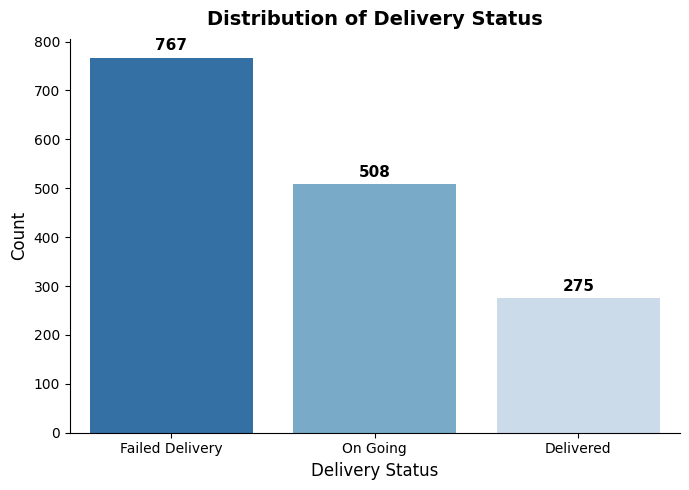

In [3315]:
## plot the target variables distribution
plt.figure(figsize=(7,5))
ax = sns.countplot(
    data=train_data, 
    x="delivery_status",
    palette="Blues_r" 
   
)

# Add counts on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=11, fontweight='bold', padding=3)

# Titles and axis labels
plt.title("Distribution of Delivery Status", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("Delivery Status", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Style cleanup
sns.despine()
plt.tight_layout()
plt.show()



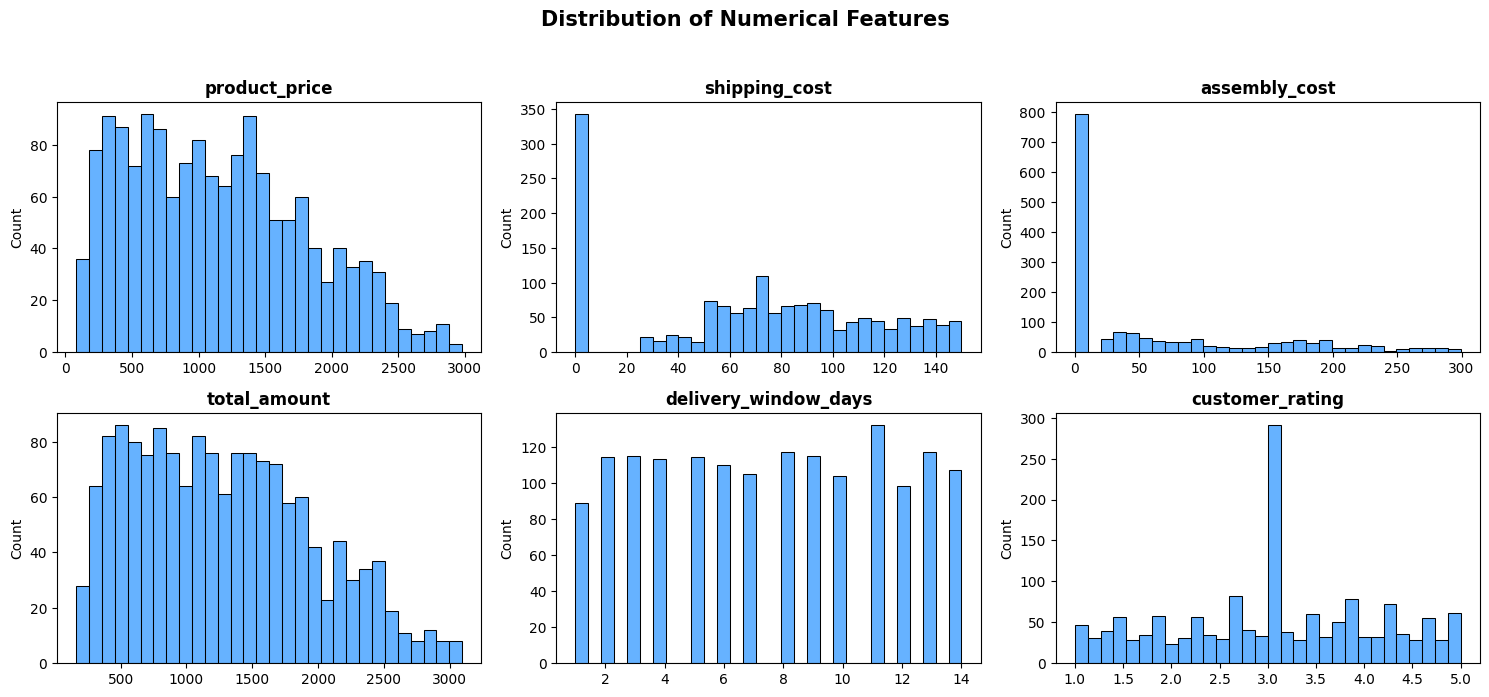

In [3316]:
##plot the distribution of all numerical variables
# Create subplots grid (3 rows, 3 columns)

numerical_features=train_data.select_dtypes(include="number").columns.tolist()

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Flatten the 2D array of axes to make indexing simple
axes = axes.flatten()

# Loop through numerical features
for index, var in enumerate(numerical_features):
    sns.histplot(train_data[var], bins=30, color="#3399FF", ax=axes[index])
    axes[index].set_title(var, fontsize=12, fontweight='bold')
    axes[index].set_xlabel("")  # optional: clean x labels
    axes[index].set_ylabel("Count")

# If there are fewer features than subplots, hide the extra axes
for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Numerical Features", fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for main title
plt.show()


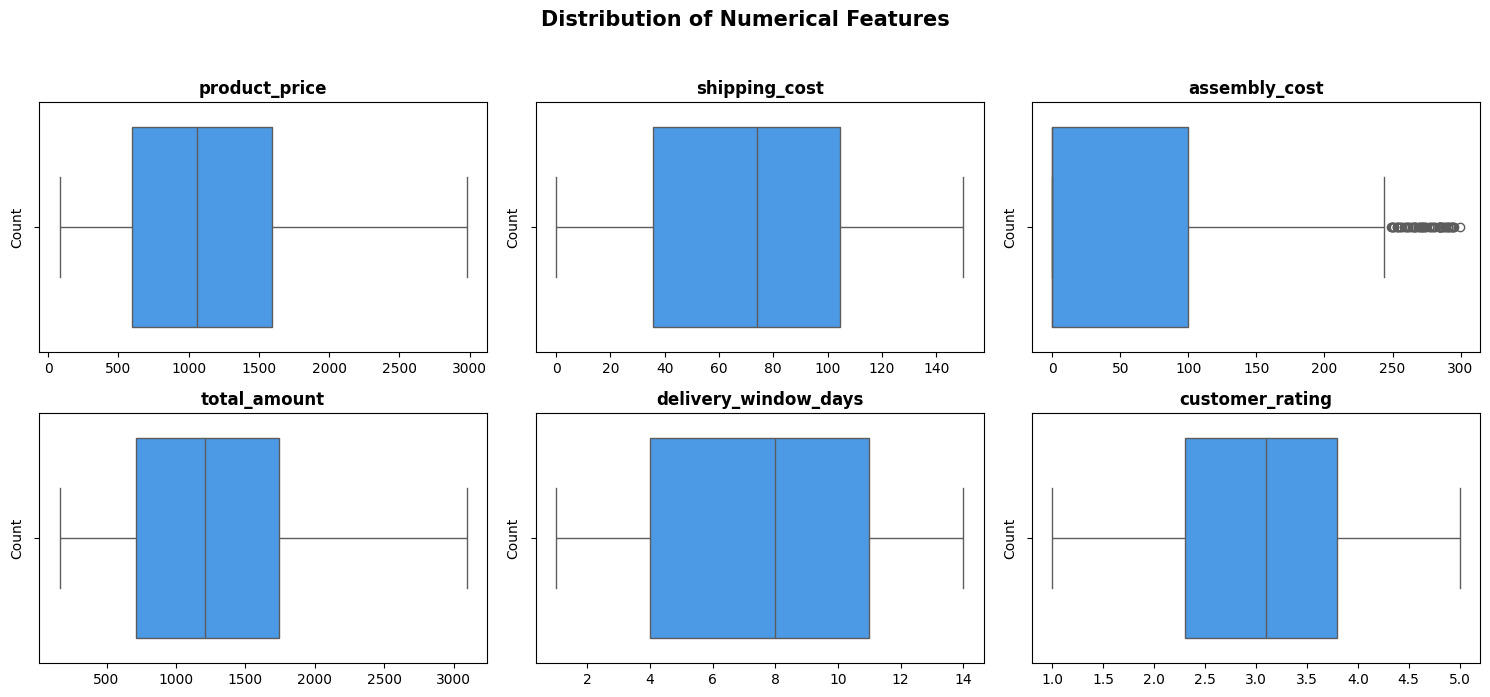

In [3317]:
##Identify the outliers for numerical variables
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Flatten the 2D array of axes to make indexing simple
axes = axes.flatten()

# Loop through numerical features
for index, var in enumerate(numerical_features):
    sns.boxplot(x=train_data[var],color="#3399FF", ax=axes[index])
    axes[index].set_title(var, fontsize=12, fontweight='bold')
    axes[index].set_xlabel("")  # optional: clean x labels
    axes[index].set_ylabel("Count")

# If there are fewer features than subplots, hide the extra axes
for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Numerical Features", fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for main title
plt.show()

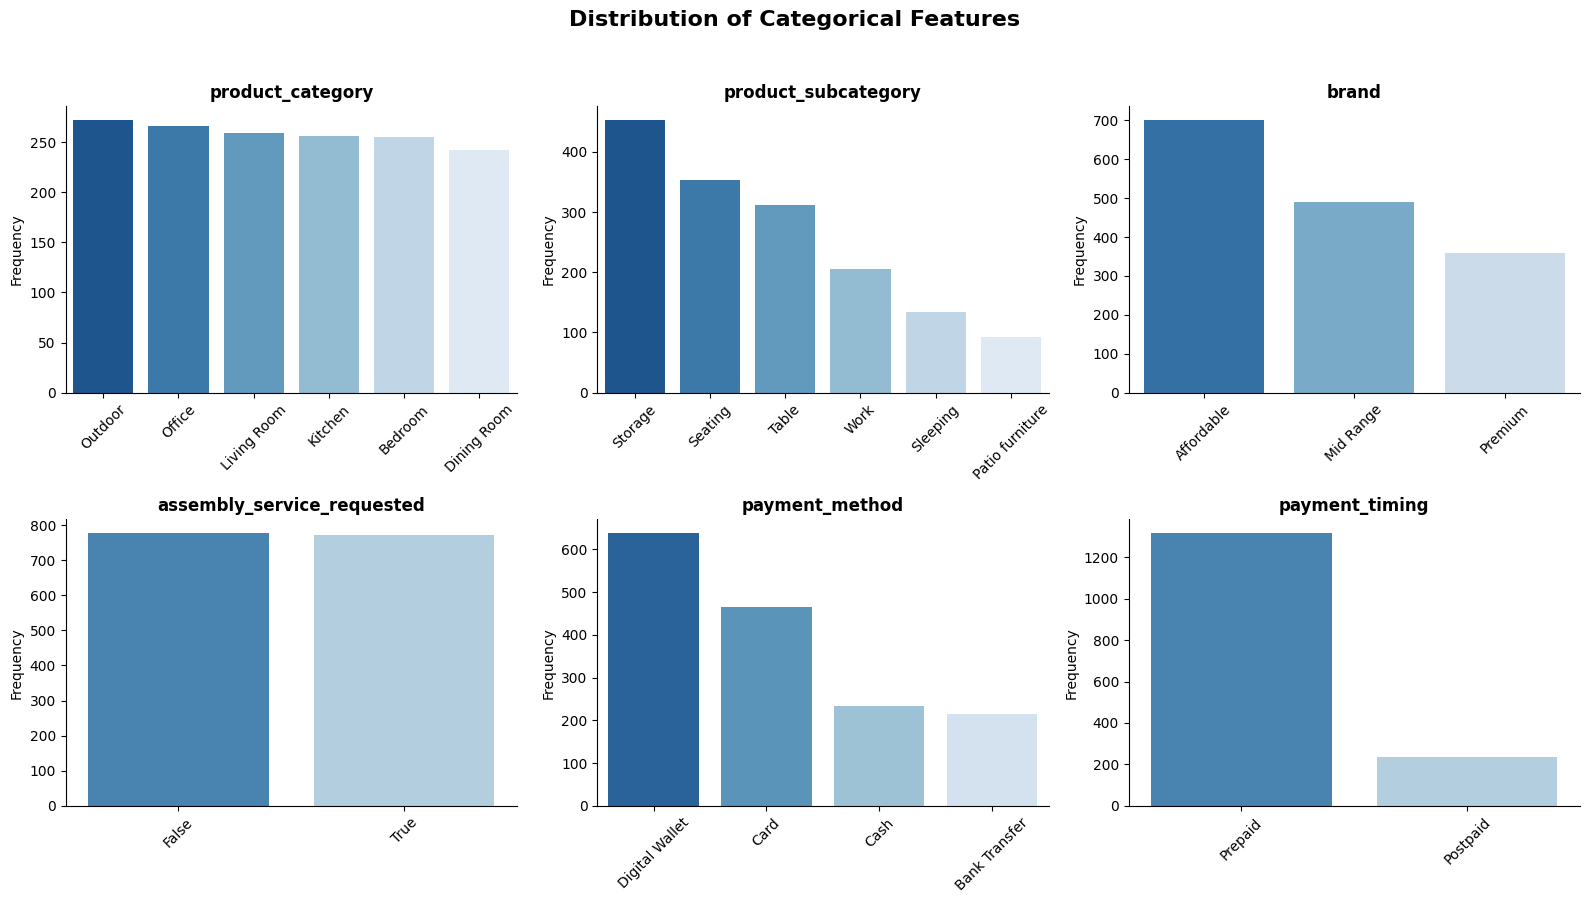

In [3318]:
## distribution for categorical variables
# Get categorical features (excluding target)
categorical_features = train_data.select_dtypes(include="object").columns.tolist()
categorical_features.remove("delivery_status")

# Create subplot grid
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

# Loop through categorical features
for index, var in enumerate(categorical_features):
    # Prepare frequency table
    table = train_data[var].value_counts().reset_index()
    table.columns = [var, "count"]
    
    # Plot bar chart
    sns.barplot(data=table,x=var,y="count",ax=axes[index],palette="Blues_r")  # optional color palette
    
    axes[index].set_title(var, fontsize=12, fontweight='bold')
    axes[index].set_xlabel("")  
    axes[index].set_ylabel("Frequency")
    axes[index].tick_params(axis='x', rotation=45)  # rotate labels for readability
    sns.despine(ax=axes[index])

# Hide extra axes if features < 9
for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Categorical Features", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### **Bivariate Analysis**

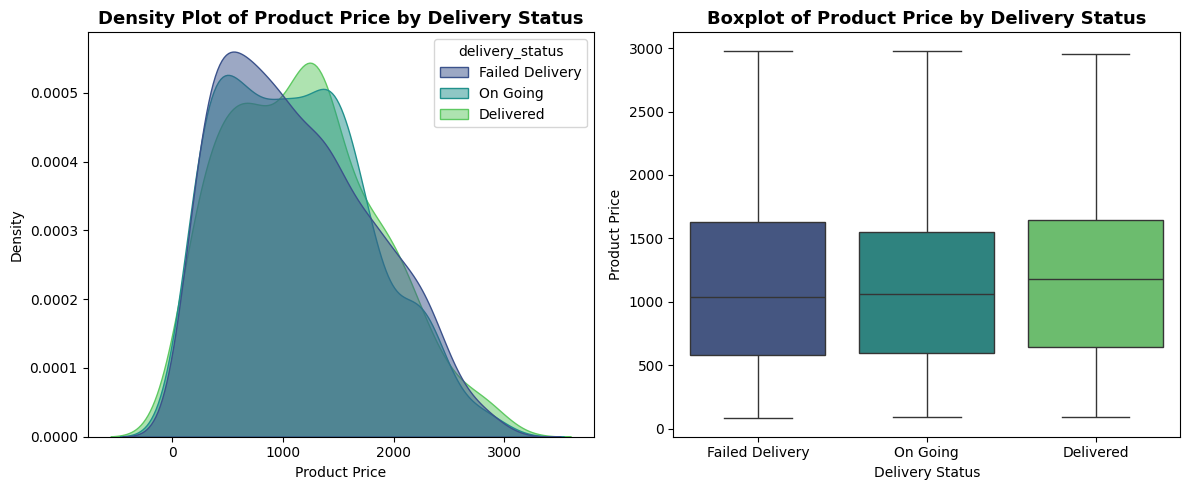

In [3319]:
##plot the density plot and boxplot with the target variable(delivery status)
plt.figure(figsize=(12,5))

# --- Subplot 1: Density plot ---
plt.subplot(1, 2, 1)
sns.kdeplot(
    data=train_data, 
    x='product_price', 
    hue='delivery_status', 
    fill=True, 
    common_norm=False, 
    alpha=0.5, 
    palette='viridis'
)
plt.title("Density Plot of Product Price by Delivery Status", fontsize=13, fontweight='bold')
plt.xlabel("Product Price")
plt.ylabel("Density")

# --- Subplot 2: Boxplot ---
plt.subplot(1, 2, 2)
sns.boxplot(
    data=train_data, 
    x='delivery_status', 
    y='product_price', 
    palette='viridis'
)
plt.title("Boxplot of Product Price by Delivery Status", fontsize=13, fontweight='bold')
plt.xlabel("Delivery Status")
plt.ylabel("Product Price")

plt.tight_layout()
plt.show()


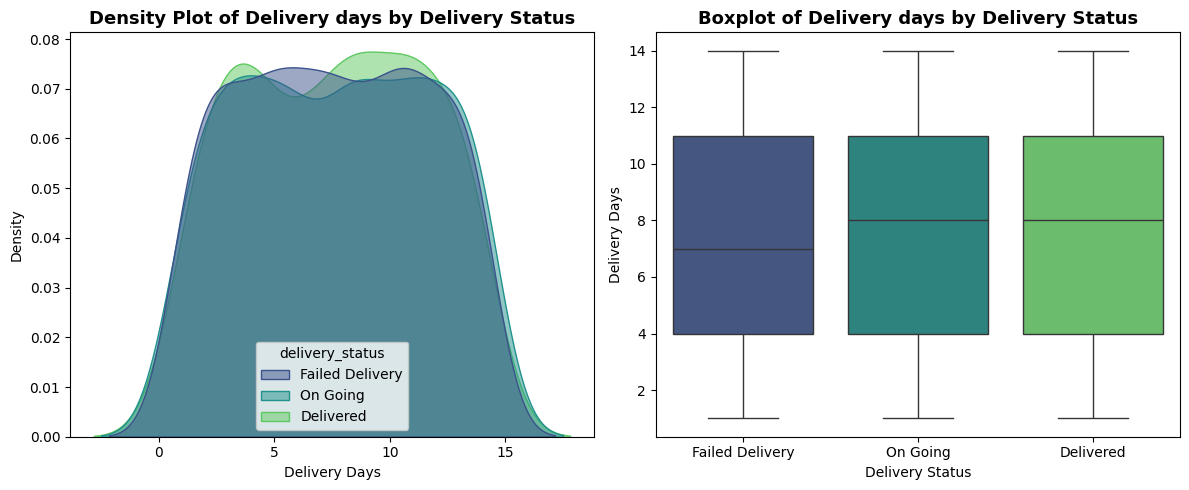

In [3320]:
##plot the density plot and boxplot with the target variable(delivery status)
plt.figure(figsize=(12,5))

# --- Subplot 1: Density plot ---
plt.subplot(1, 2, 1)
sns.kdeplot(
    data=train_data, 
    x='delivery_window_days', 
    hue='delivery_status', 
    fill=True, 
    common_norm=False, 
    alpha=0.5, 
    palette='viridis'
)
plt.title("Density Plot of Delivery days by Delivery Status", fontsize=13, fontweight='bold')
plt.xlabel("Delivery Days")
plt.ylabel("Density")

# --- Subplot 2: Boxplot ---
plt.subplot(1, 2, 2)
sns.boxplot(
    data=train_data, 
    x='delivery_status', 
    y='delivery_window_days', 
    palette='viridis'
)
plt.title("Boxplot of Delivery days by Delivery Status", fontsize=13, fontweight='bold')
plt.xlabel("Delivery Status")
plt.ylabel("Delivery Days")

plt.tight_layout()
plt.show()

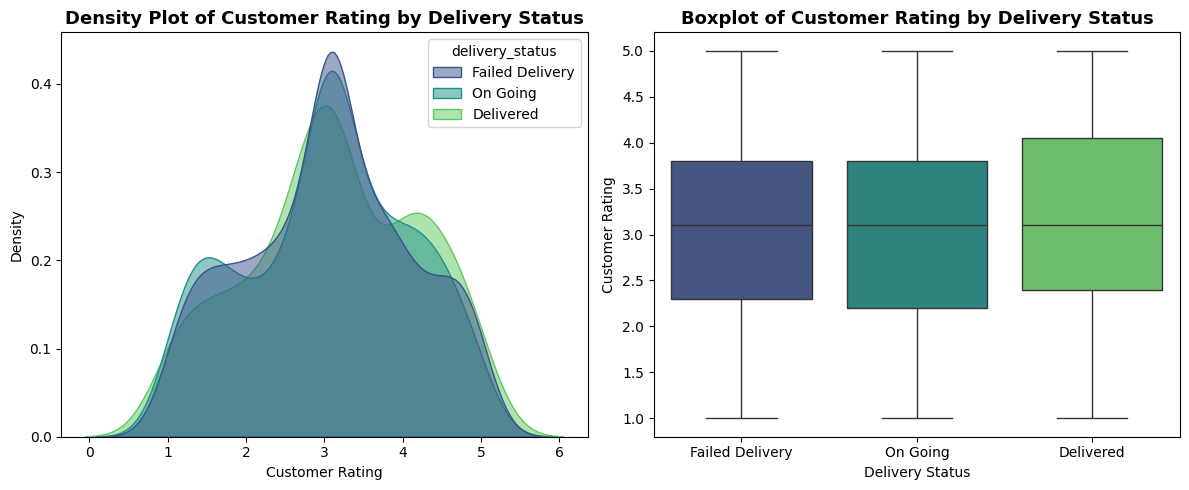

In [3321]:
##plot the density plot and boxplot with the target variable(delivery status)
plt.figure(figsize=(12,5))

# --- Subplot 1: Density plot ---
plt.subplot(1, 2, 1)
sns.kdeplot(
    data=train_data, 
    x='customer_rating', 
    hue='delivery_status', 
    fill=True, 
    common_norm=False, 
    alpha=0.5, 
    palette='viridis'
)
plt.title("Density Plot of Customer Rating by Delivery Status", fontsize=13, fontweight='bold')
plt.xlabel("Customer Rating")
plt.ylabel("Density")

# --- Subplot 2: Boxplot ---
plt.subplot(1, 2, 2)
sns.boxplot(
    data=train_data, 
    x='delivery_status', 
    y='customer_rating', 
    palette='viridis'
)
plt.title("Boxplot of Customer Rating by Delivery Status", fontsize=13, fontweight='bold')
plt.xlabel("Delivery Status")
plt.ylabel("Customer Rating")

plt.tight_layout()
plt.show()

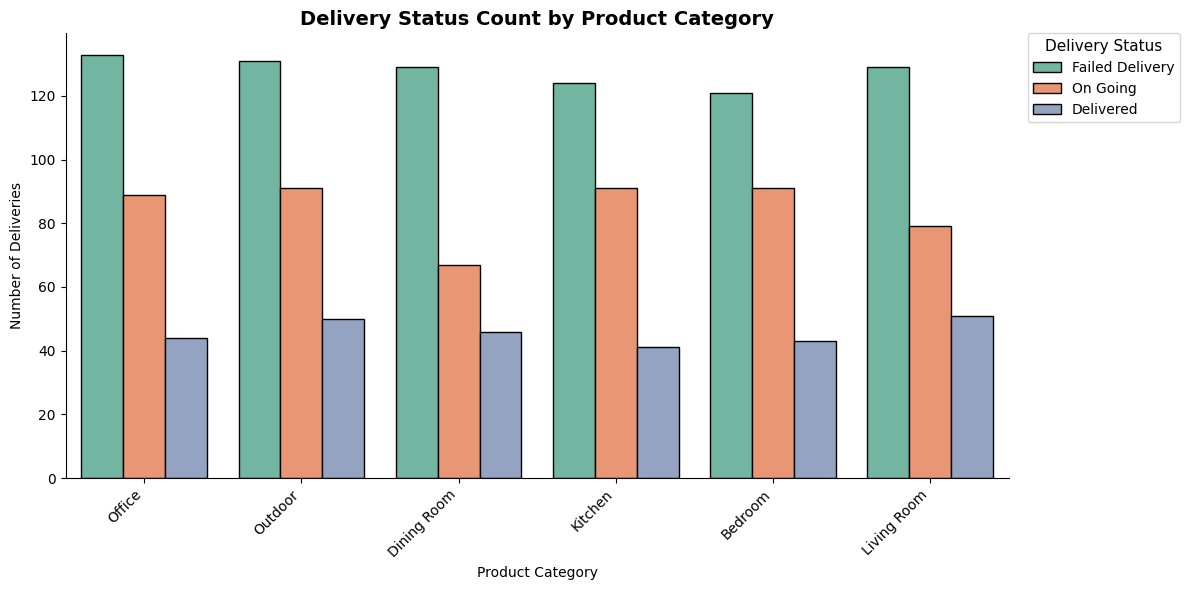

In [3322]:
##plot the cluster bar chart with product category and delivery status
plt.figure(figsize=(12,6))
sns.countplot(
    data=train_data,
    x='product_category',
    hue='delivery_status',
    palette='Set2',
    edgecolor='black'
)

plt.title("Delivery Status Count by Product Category", fontsize=14, fontweight='bold')
plt.xlabel("Product Category")
plt.ylabel("Number of Deliveries")
plt.xticks(rotation=45, ha='right')

# Move legend outside plot area
plt.legend(
    title='Delivery Status',
    bbox_to_anchor=(1.02, 1),  # move to the right
    loc='upper left',
    borderaxespad=0,
    fontsize=10,
    title_fontsize=11
)

sns.despine()
plt.tight_layout()
plt.show()

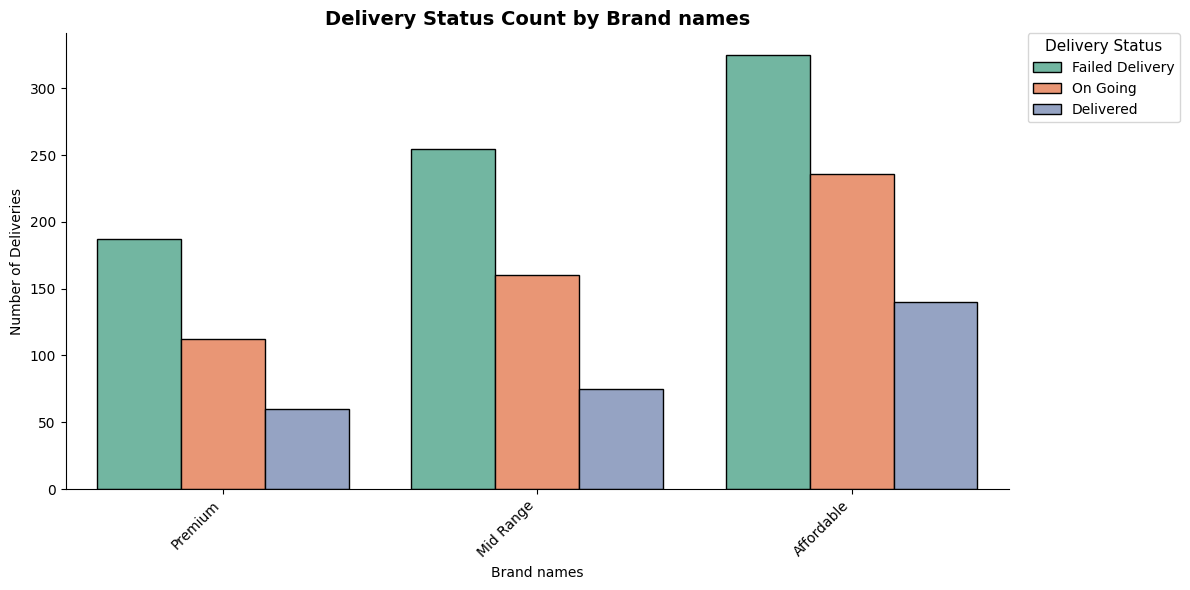

In [3323]:
##plot the cluster bar chart with Brand names and delivery status
plt.figure(figsize=(12,6))
sns.countplot(
    data=train_data,
    x='brand',
    hue='delivery_status',
    palette='Set2',
    edgecolor='black'
)

plt.title("Delivery Status Count by Brand names", fontsize=14, fontweight='bold')
plt.xlabel("Brand names")
plt.ylabel("Number of Deliveries")
plt.xticks(rotation=45, ha='right')

# Move legend outside plot area
plt.legend(
    title='Delivery Status',
    bbox_to_anchor=(1.02, 1),  # move to the right
    loc='upper left',
    borderaxespad=0,
    fontsize=10,
    title_fontsize=11
)

sns.despine()
plt.tight_layout()
plt.show()

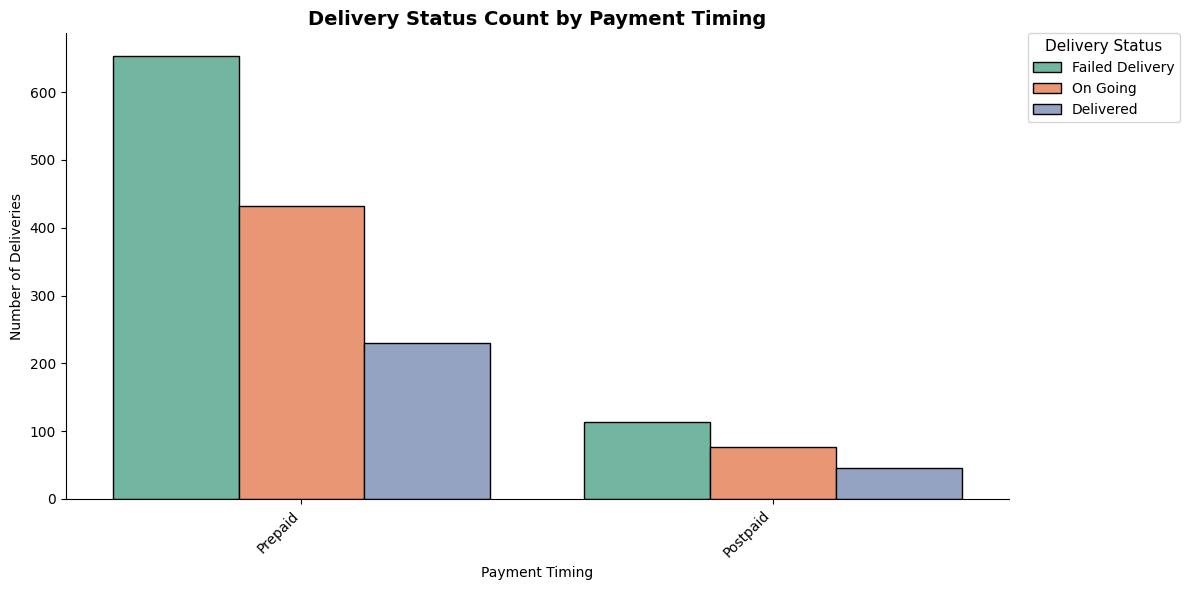

In [3324]:
##plot the cluster bar chart with payment timing and delivery status
plt.figure(figsize=(12,6))
sns.countplot(
    data=train_data,
    x='payment_timing',
    hue='delivery_status',
    palette='Set2',
    edgecolor='black'
)

plt.title("Delivery Status Count by Payment Timing", fontsize=14, fontweight='bold')
plt.xlabel("Payment Timing")
plt.ylabel("Number of Deliveries")
plt.xticks(rotation=45, ha='right')

# Move legend outside plot area
plt.legend(
    title='Delivery Status',
    bbox_to_anchor=(1.02, 1),  # move to the right
    loc='upper left',
    borderaxespad=0,
    fontsize=10,
    title_fontsize=11
)

sns.despine()
plt.tight_layout()
plt.show()

### **Multivariate Analysis**

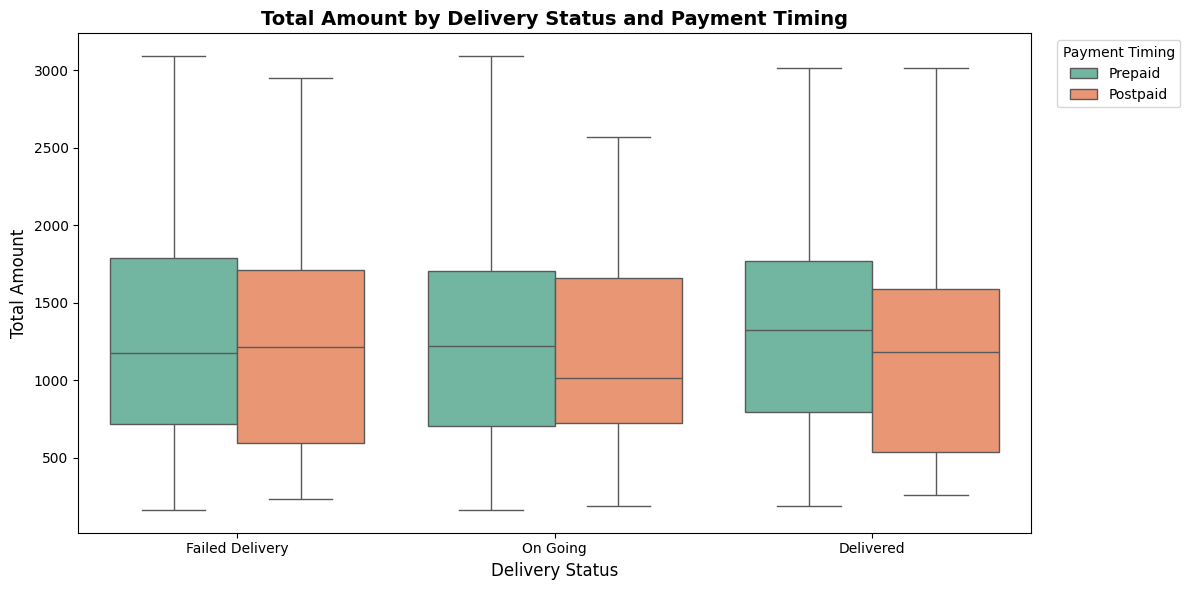

In [3325]:
## plot delivery status,total amount and payment timing
plt.figure(figsize=(12,6))
sns.boxplot(
    data=train_data,
    x='delivery_status',
    y='total_amount',
    hue='payment_timing',
    palette='Set2'
)

plt.title("Total Amount by Delivery Status and Payment Timing", fontsize=14, fontweight='bold')
plt.xlabel("Delivery Status", fontsize=12)
plt.ylabel("Total Amount", fontsize=12)
plt.legend(title="Payment Timing", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


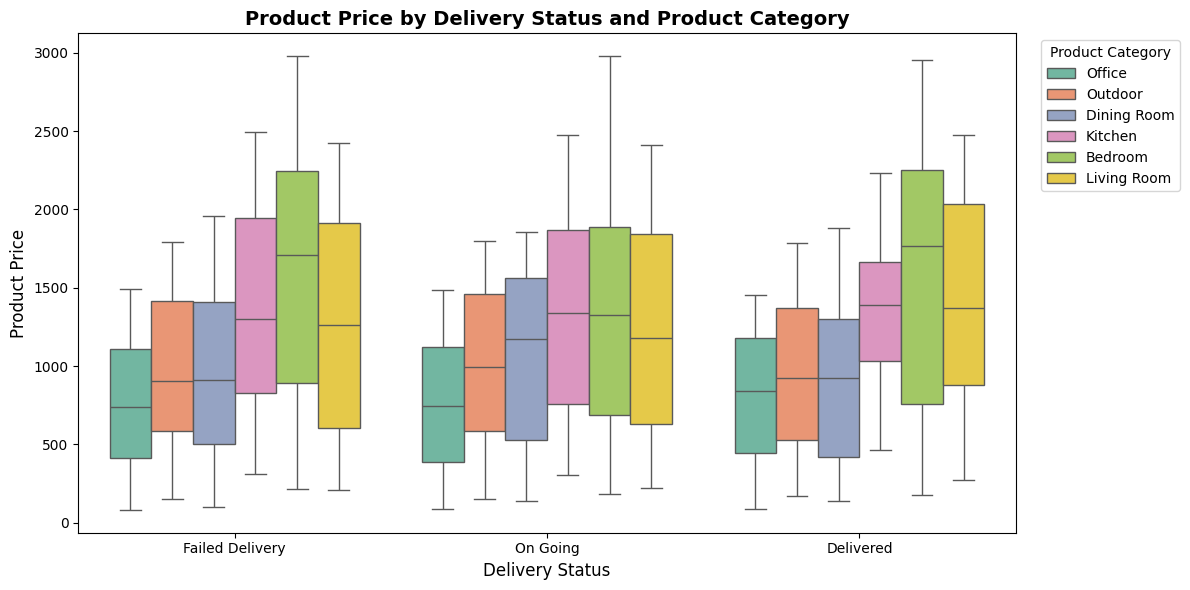

In [3326]:
## plot delivery status,product price and product category
plt.figure(figsize=(12,6))
sns.boxplot(
    data=train_data,
    x='delivery_status',
    y='product_price',
    hue='product_category',
    palette='Set2'
)

plt.title("Product Price by Delivery Status and Product Category", fontsize=14, fontweight='bold')
plt.xlabel("Delivery Status", fontsize=12)
plt.ylabel("Product Price", fontsize=12)
plt.legend(title="Product Category", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

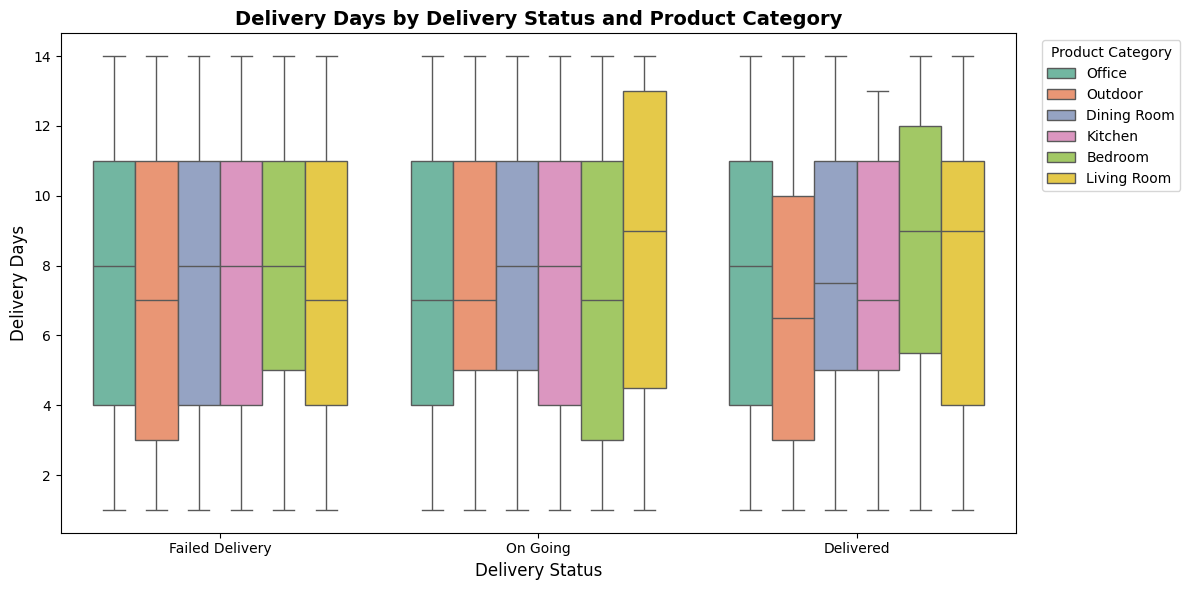

In [3327]:
## plot delivery status,delivery window days and product category
plt.figure(figsize=(12,6))
sns.boxplot(
    data=train_data,
    x='delivery_status',
    y='delivery_window_days',
    hue='product_category',
    palette='Set2'
)

plt.title("Delivery Days by Delivery Status and Product Category", fontsize=14, fontweight='bold')
plt.xlabel("Delivery Status", fontsize=12)
plt.ylabel("Delivery Days", fontsize=12)
plt.legend(title="Product Category", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

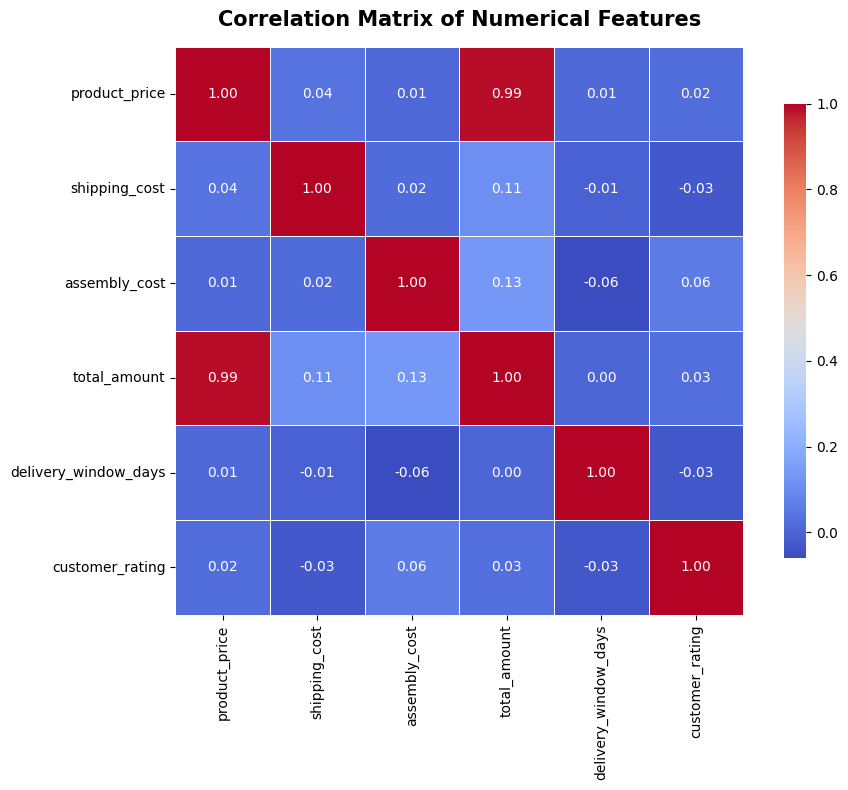

In [3328]:
##plot correlation matrix
numeric_df=train_data[numerical_features]
##calculate  the correaltion matrix
corr_matrix=numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix, 
    annot=True,          # show correlation values
    fmt=".2f",           # format to 2 decimals
    cmap="coolwarm",     # diverging color palette
    square=True,         # make cells square-shaped
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix of Numerical Features", fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()


In [3329]:
##Multicorlinerity checks for numerical variables
# Create a copy (optional)
X_vif = numeric_df.dropna()  # Drop NaNs to avoid calculation issues

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values(by="VIF", ascending=False)

Feature          VIF
3          total_amount  6247.620856
0         product_price  5258.092782
2         assembly_cost    32.182423
1         shipping_cost    24.361044
5       customer_rating     5.143943
4  delivery_window_days     3.632479

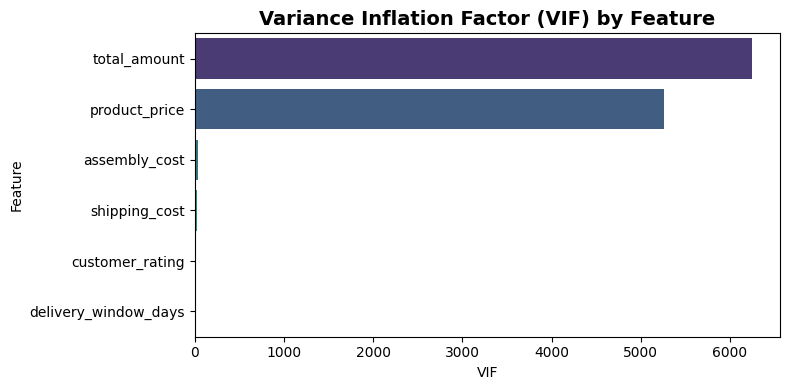

In [3330]:
##plot the Multicolinerity 
plt.figure(figsize=(8,4))
sns.barplot(data=vif_data.sort_values(by='VIF', ascending=False), x='VIF', y='Feature', palette='viridis')
plt.title('Variance Inflation Factor (VIF) by Feature', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [3331]:
##drop total amount due to high multicolinearity with product price and shipping cost
train_data=train_data.drop(columns=["total_amount"],axis=1)
X_test_impute=X_test_impute.drop(columns=["total_amount"],axis=1)

In [3332]:
X_vif = train_data.select_dtypes(include="number").dropna()  # Drop NaNs to avoid calculation issues

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values(by="VIF", ascending=False)

Feature       VIF
4       customer_rating  5.141784
3  delivery_window_days  3.632404
0         product_price  3.464187
1         shipping_cost  2.857258
2         assembly_cost  1.521409

### **Multivariate Normality checks**

In [3333]:
# Perform Mardia's test
mardia_test = pg.multivariate_normality(numeric_df, alpha=0.05)

print(mardia_test)

##multivariae normality fails

HZResults(hz=np.float64(9.539906632672649), pval=np.float64(0.0), normal=False)


### **Multivariate Outliers checks**

In [3334]:
from scipy.stats import chi2
##set random seed value
np.random.seed(42)

#Fit a robust covariance estimator
robust_cov = MinCovDet().fit(numeric_df)

# Robust Mahalanobis distance
mahal_dist = robust_cov.mahalanobis(numeric_df)

#Detect outliers
# Use chi-square threshold with p-value 0.975
threshold = chi2.ppf(0.975, df=numeric_df.shape[1])

outliers = mahal_dist > threshold
print("Number of outliers detected:", np.sum(outliers)) ##number of multivariate outliers

Number of outliers detected: 587


### **FAMD**

In [3335]:
famd_data=X_train_impute.copy() ##get the copy of orginal dataframe

famd=prince.FAMD(n_components=5,random_state=42) ##intilized the object
famd_result=famd.fit_transform(famd_data) ##apply FAMD 

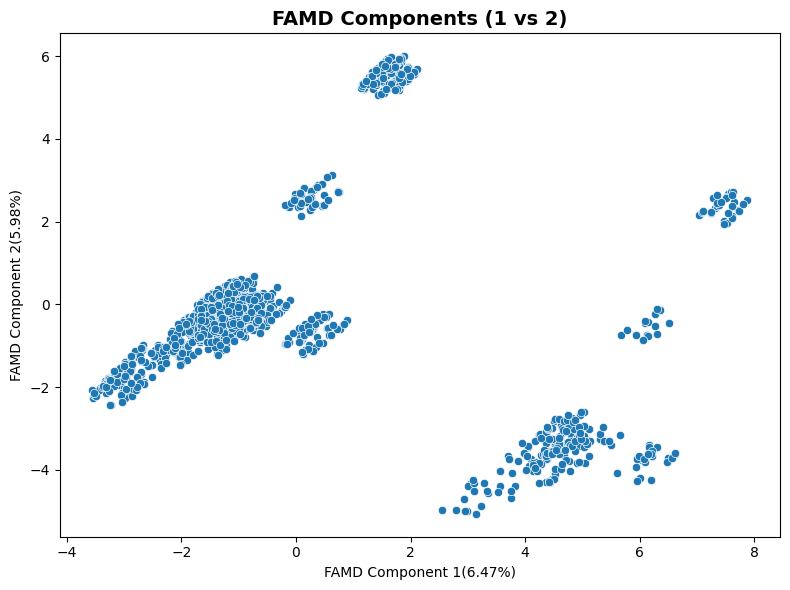

In [3336]:
##plot the first two dimentions of FAMD result
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=famd_result,
    x=0, y=1,
    palette='Set2'
)
plt.title('FAMD Components (1 vs 2)', fontsize=14, fontweight='bold')
plt.xlabel('FAMD Component 1(6.47%)')
plt.ylabel('FAMD Component 2(5.98%)')
plt.tight_layout()
plt.show()

In [3337]:
famd.eigenvalues_summary ##cumalative percentage of famd components

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              6.245        10.96%                     10.96%
1              5.730        10.05%                     21.01%
2              5.563         9.76%                     30.77%
3              4.720         8.28%                     39.05%
4              4.031         7.07%                     46.12%

In [3338]:
##“Although the first two FAMD components explain approximately 17% of the total variance, 
##the projection reveals visually distinct clusters, suggesting the presence of underlying patterns in the data. However, 
##due to low explained inertia, clustering results should be interpreted cautiously.”

In [3339]:
# Ensure consistent labeling
famd_result["Outlier"] = np.where(outliers, "Outlier", "Normal")

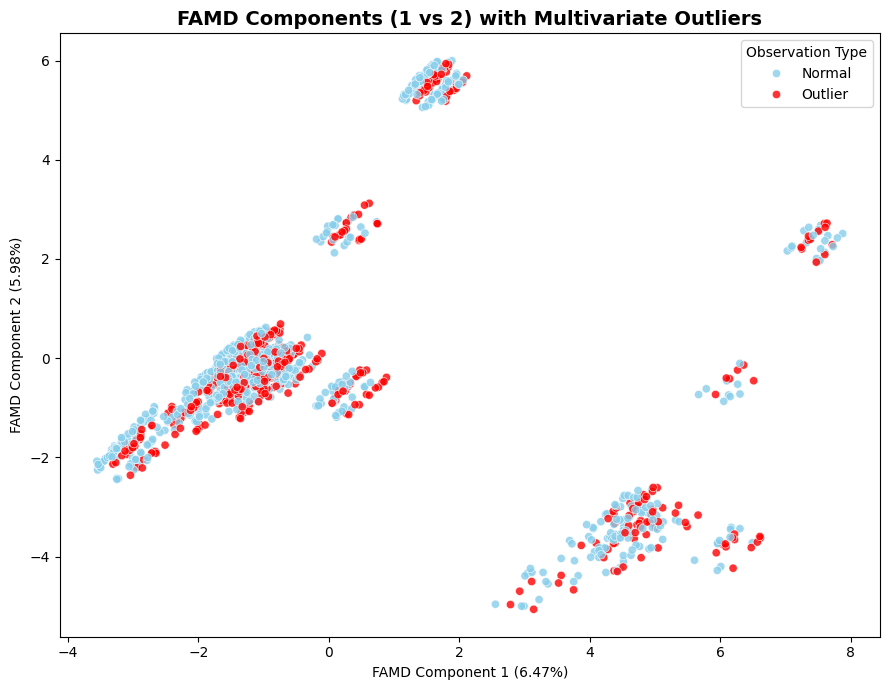

In [3340]:
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=famd_result,
    x=0, y=1,
    hue="Outlier",
    palette={"Normal": "skyblue", "Outlier": "red"},
    alpha=0.8
)
plt.title("FAMD Components (1 vs 2) with Multivariate Outliers", fontsize=14, fontweight='bold')
plt.xlabel("FAMD Component 1 (6.47%)")
plt.ylabel("FAMD Component 2 (5.98%)")
plt.legend(title="Observation Type")
plt.tight_layout()
plt.show()

### **Addresing the Decision Boundary**

In [3341]:
x=famd.transform(X_train_impute)
y=Y_train

##mapping y variable with the numeric values
y_map={"Failed Delivery":0,"On Going":1,"Delivered":2}
y=y.map(y_map)

In [3342]:
##perform LDA
lda=LinearDiscriminantAnalysis(n_components=2)
x_lda=lda.fit_transform(x,y)

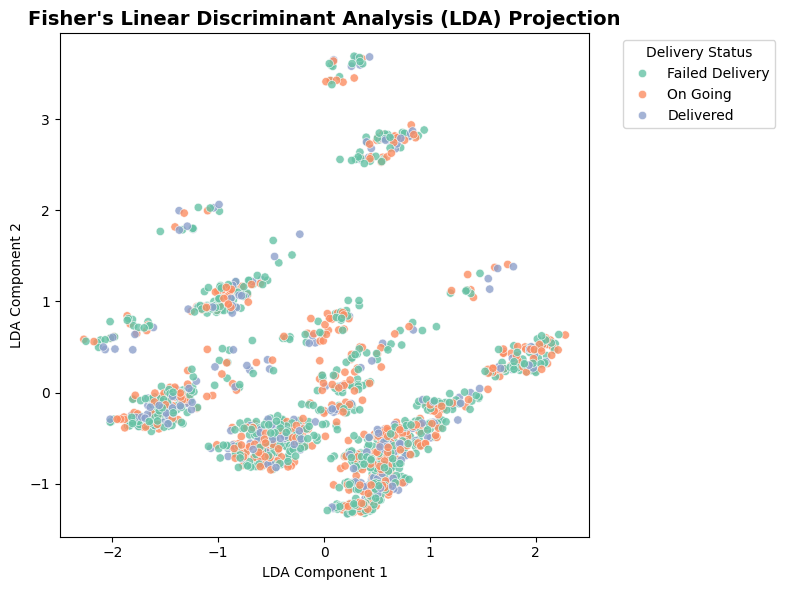

In [3343]:
##visualize the decision boundary
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=x_lda[:, 0],
    y=x_lda[:, 1],
    hue=train_data['delivery_status'],
    palette='Set2',
    alpha=0.8
)

plt.title("Fisher's Linear Discriminant Analysis (LDA) Projection", fontsize=14, fontweight='bold')
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend(title="Delivery Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [3344]:
test_data=pd.concat([X_test_impute,Y_test],axis=1)
##save the test set and train set seperately
train_data.to_csv("../dataset/train_data.csv")
test_data.to_csv("../dataset/test_data.csv")